In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# UNBIASED ESTIMATOR

In [2]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_i, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Apply the extrapolation formula for multiple measurements (2 halves)
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [3]:
class def_variable_parameters:
    
    def __init__(self, betweenVar, withinVar, mean):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean

In [4]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = 0.6):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

In [5]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=(10, 30, 60, 120, 240),
                   range_measurements=(2, 4, 8, 16),
                   n_repetitions=300,
                   true_correlation=0.6):

    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_raw, list_unbiased = [], []
#            model_spec = make_model_spec(n_meas) 

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(crowding_param, rsvp_param, n_samples, n_meas,
                                                  correlation=true_correlation)
                wMeans = sim['crowding_measurement']
                zMeans = sim['rsvp_measurement']

                # 2) --- raw correlation & noise ceiling --------------
                raw_corr, _ = pearsonr(wMeans, zMeans)

                W = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                Z = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                Rxx = compute_noise_ceiling_splitHalf(W)
                Ryy = compute_noise_ceiling_splitHalf(Z)
                lam = np.sqrt(np.abs(Rxx * Ryy))

                unbiased_corr = raw_corr / lam
                
                # 3) --- stash ---------------------------------------
                list_raw.append(raw_corr)
                list_unbiased.append(unbiased_corr)

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "rmse_raw":    rmse(list_raw),
                "rmse_unbiased":    rmse(list_unbiased)
            })

        print(f"done with n_samples = {n_samples}")

    return pd.DataFrame(results_corr)

# EXPLORING PARAMETER SPACE

In [6]:
def plot_raw_unbiased(results_corr_df, x_values, x_subset_name, line_values, line_subset_name, line_label,
                      y_measured_name, y_rceiling_name, x_label, y_label, colors, y_lim=(-0.02, 0.25)):

    plt.figure(figsize=(10, 8))

    for i, lv in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == lv]
        color  = colors[i]

        x = subset[x_subset_name].to_numpy()       
        y_meas = subset[y_measured_name].to_numpy()
        y_rc   = subset[y_rceiling_name].to_numpy()

        plt.plot(x, y_meas, '-o',  color=color, label=f"{lv} (Raw)")
        plt.plot(x, y_rc,   '--o', color=color, label=f"{lv} (Unbiased)")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(y_lim)
    plt.yticks(np.arange(0, y_lim[1]+0.1, step=0.1), size=16)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=16)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Build unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    plt.legend(unique_handles, unique_labels, title=line_label,
               bbox_to_anchor=(1.05, 1), loc='upper left',
               title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [7]:
def plot_raw_unbiased(results_corr_df, x_values, x_subset_name, 
                      y_measured_name, y_rceiling_name, x_label, y_label, colors, y_lim=(-0.02, 0.25)):

    plt.figure(figsize=(6, 6))

    color = "dimgray"

    x = results_corr_df[x_subset_name].to_numpy()       
    y_meas = results_corr_df[y_measured_name].to_numpy()
    y_rc   = results_corr_df[y_rceiling_name].to_numpy()

    plt.plot(x, y_meas, '-o',  label=f"Raw")
    plt.plot(x, y_rc,   '--o', label=f"Unbiased")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(y_lim)
    plt.yticks(np.arange(0, y_lim[1]+0.1, step=0.1), size=18)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=18)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    plt.legend(loc='upper right', title_fontsize=16, fontsize=18)

    plt.tight_layout()
    plt.show()

### rho = 0.6, VR = 1

In [8]:
crowding_param = def_variable_parameters(betweenVar = 0.06, withinVar = 0.06, mean = 0.25)

rsvp_param = def_variable_parameters(betweenVar = 0.06, withinVar = 0.06, mean = 2.9)

In [9]:
results_corr_df = run_simulation(crowding_param, rsvp_param,
                   range_samples=(20, 40, 80, 160, 320, 640),
                   range_measurements=(2, 4, 8, 16),
                   n_repetitions=1000,
                   true_correlation=0.6)

done with n_samples = 20
done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320
done with n_samples = 640


In [10]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.tab10(np.linspace(0, 0.5, len(sample_sizes)))
n_measurements = sorted(results_corr_df["n_measurements"].unique())

# 1) RMSE
plot_raw_unbiased(
    results_corr_df,
    x_values=n_measurements,
    x_subset_name='n_measurements',
    line_values=sample_sizes,
    line_subset_name='n_samples',
    line_label='Sample size',
    y_measured_name='rmse_raw',
    y_rceiling_name='rmse_unbiased',
    x_label='Number of measurements',
    y_label='RMSE',
    colors=colors,
    y_lim=(-0.01, 0.4)  # adjust as needed
)

TypeError: plot_raw_unbiased() got an unexpected keyword argument 'line_values'

In [ ]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.tab10(np.linspace(0, 0.5, len(sample_sizes)))

plot_raw_unbiased(
    results_corr_df[results_corr_df['n_measurements']==2],
    x_values=sample_sizes,
    x_subset_name='n_samples',
    y_measured_name='rmse_raw',
    y_rceiling_name='rmse_unbiased',
    x_label='Sample size',
    y_label='RMSE',
    colors=colors,
    y_lim=(-0.02, 0.5))

In [ ]:
n_measurements = sorted(results_corr_df["n_measurements"].unique())
colors = plt.cm.tab10(np.linspace(0, 0.5, len(sample_sizes)))

plot_raw_unbiased(
    results_corr_df[results_corr_df['n_samples']==40],
    x_values=n_measurements,
    x_subset_name='n_measurements',
    y_measured_name='rmse_raw',
    y_rceiling_name='rmse_unbiased',
    x_label='Number of thresholds',
    y_label='RMSE',
    colors=colors,
    y_lim=(-0.02, 0.5))

### rho = 0.3, VR = 0.5

In [ ]:
crowding_param = def_variable_parameters(betweenVar = 0.06, withinVar = 0.03, mean = 0.25)

rsvp_param = def_variable_parameters(betweenVar = 0.06, withinVar = 0.03, mean = 2.9)

In [ ]:
results_corr_df = run_simulation(crowding_param, rsvp_param,
                   range_samples=(20, 40, 80, 160, 320, 640),
                   range_measurements=(2, 4, 8, 16),
                   n_repetitions=1000,
                   true_correlation=0.3)

In [ ]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.tab10(np.linspace(0, 0.5, len(sample_sizes)))

plot_raw_unbiased(
    results_corr_df[results_corr_df['n_measurements']==2],
    x_values=sample_sizes,
    x_subset_name='n_samples',
    y_measured_name='rmse_raw',
    y_rceiling_name='rmse_unbiased',
    x_label='Sample size',
    y_label='RMSE',
    colors=colors,
    y_lim=(-0.02, 0.5))

In [ ]:
n_measurements = sorted(results_corr_df["n_measurements"].unique())
colors = plt.cm.tab10(np.linspace(0, 0.5, len(sample_sizes)))

plot_raw_unbiased(
    results_corr_df[results_corr_df['n_samples']==40],
    x_values=n_measurements,
    x_subset_name='n_measurements',
    y_measured_name='rmse_raw',
    y_rceiling_name='rmse_unbiased',
    x_label='Number of thresholds',
    y_label='RMSE',
    colors=colors,
    y_lim=(-0.02, 0.5))

# ESTIMATOR SELECTION

In [ ]:
import numpy as np

def choose_best_estimator(n_samples, n_meas, rho,
                          obs_var_x, meas_var_x,
                          obs_var_y, meas_var_y):
    """
    Decide whether raw or R-ceiling corrected Pearson r
    has lower RMSE, accounting for different variances in X and Y.

    Parameters
    ----------
    n_samples : int
        Number of observers (sample size).
    n_meas : int
        Number of repeated measurements per observer.
    rho : float
        True correlation (–1 to 1).
    obs_var_x : float
        Variance of true X thresholds across observers.
    meas_var_x : float
        Measurement noise variance for X.
    obs_var_y : float
        Variance of true Y thresholds across observers.
    meas_var_y : float
        Measurement noise variance for Y.

    Returns
    -------
    choice : str
        'raw' or 'r-ceiling'
    rmse_raw : float
    rmse_rceil : float
    """
    # reliability for X and Y
    Rx = obs_var_x / (obs_var_x + meas_var_x / n_meas)
    Ry = obs_var_y / (obs_var_y + meas_var_y / n_meas)
    lam = np.sqrt(Rx * Ry)

    # approximate sampling variance of Pearson r
    var_r = (1 - rho**2)**2 / (n_samples - 1)

    # approximate RMSEs
    rmse_raw = np.sqrt(var_r + (rho * (1 - lam))**2)
    rmse_rceil = np.sqrt(var_r / lam**2)

    choice = 'raw' if rmse_raw < rmse_rceil else 'r-ceiling'
    return choice, rmse_raw, rmse_rceil

In [ ]:
choice, rmse_raw, rmse_rc = choose_best_estimator(
    n_samples=30,
    n_meas=2,
    rho=0.6,
    obs_var_x=0.0254,
    meas_var_x=0.0141*10,
    obs_var_y=0.056,
    meas_var_y=0.0157*10
)
print(f"Best estimator: {choice}")
print(f"RMSE raw = {rmse_raw:.3f}, RMSE r-ceiling = {rmse_rc:.3f}")

# --------------------------------------------------------------------------
# ------------------------------- ARCHIVE -------------------------------
# --------------------------------------------------------------------------

# RELIABILITIES

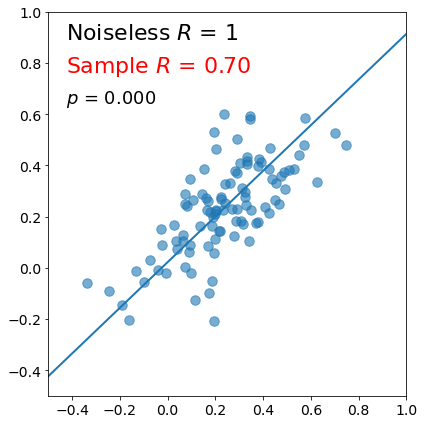

In [140]:
# Parameters: you can change these to your desired values
mu_x, mu_y = 0.25, 0.25
var_x, var_y = 0.025, 0.025
noise_std = np.sqrt(.014)
n_points = 100
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=0.6)
x_line_n = np.linspace(-3, 3, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2, label='TLS fit (noisy)')
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(-.5, 1)
plt.ylim(-.5, 1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

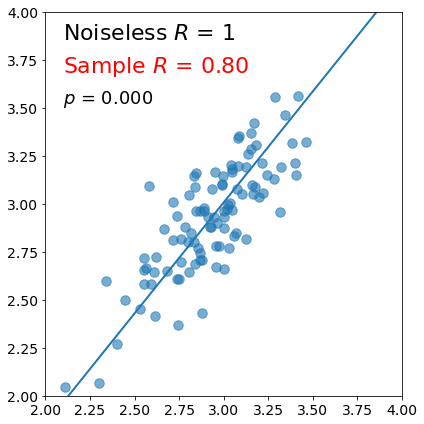

In [141]:
# Parameters
mu_x, mu_y = 2.9, 2.9
var_x, var_y = 0.06, 0.06
noise_std = np.sqrt(.016)
rho = 1

# Construct covariance matrix
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])

# Draw samples
x, y = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=n_points).T

x_noisy = x + np.random.normal(0, noise_std, n_points)
y_noisy = y + np.random.normal(0, noise_std, n_points)
slope_n, intercept_n = tls_regression(x_noisy, y_noisy)
r_value, p_value = pearsonr(x_noisy, y_noisy)

plt.figure(figsize=(6, 6))
plt.scatter(x_noisy, y_noisy, s=90, alpha=.6)
x_line_n = np.linspace(-3, 5, 100)
plt.plot(x_line_n, slope_n * x_line_n + intercept_n, linewidth=2)
plt.text(0.05, 0.97, f'Noiseless $R$ = 1',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='black')
plt.text(0.05, 0.89, f'Sample $R$ = {r_value:.2f}',
         transform=plt.gca().transAxes, va='top', fontsize=22, color='red')
plt.text(0.05, 0.8, f'$p$ = {p_value:.3f}',
         transform=plt.gca().transAxes, va='top', fontsize=18, color='black')
plt.xlim(2, 4)
plt.ylim(2, 4)
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()

plt.show()

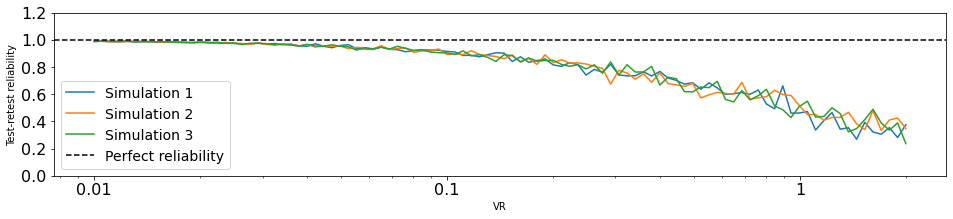

In [147]:
# Parameters
mu_x, mu_y = 2, 2
var_x, var_y = 1, 1
rho = 1
cov_xy = rho * np.sqrt(var_x * var_y)
cov_matrix = np.array([[var_x, cov_xy],
                       [cov_xy, var_y]])
N = 100
data = np.random.multivariate_normal([mu_x, mu_y], cov_matrix, size=N)

# Define a range of noise levels
noise_levels = np.logspace(-2, 0.3, num=100)
n_traces = 3  # number of replicate traces

# Preallocate array to hold Pearson r values
results = np.empty((n_traces, noise_levels.size))

# Simulate and compute Pearson r for each trace and sample size
for t in range(n_traces):
    for idx, noise_var in enumerate(noise_levels):
        noise = np.random.normal(0, np.sqrt(noise_var), size=data.shape)
        noisy_data = data + noise
        r, _ = pearsonr(noisy_data[:, 0], noisy_data[:, 1])
        results[t, idx] = r

plt.figure(figsize=(16, 3))
for t in range(n_traces):
    plt.plot(noise_levels, results[t], label=f'Simulation {t+1}')
plt.axhline(1, color='black', ls='--', label = 'Perfect reliability')
plt.xlabel('VR')
plt.ylabel("Test-retest reliability")
plt.xticks(size=16)
plt.yticks(size=16)
#plt.xlim(0,100)
plt.ylim(0,1.2)
plt.xscale('log')
ax = plt.gca()
# Use %g so you get regular decimal notation (e.g. 0.1, 1, 10) instead of 1e-1, 1e0, 1e1
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

# And adjust tick label sizes
ax.tick_params(axis='x', labelsize=16)
plt.legend(fontsize=14)
plt.show()